In [11]:
# generate dataset based on the bif file
from utils.data_generation import generate_dataset
G,data=generate_dataset('./_raw_bayesian_nets/asia.bif', n=10000)

In [22]:
# pickle the data
import pickle
def save_data_to_file(data, filename):
    """
    Save data to a file using pickle
    
    Parameters:
    data: Any Python object that can be pickled
    filename (str): Name of the file to save the data to
    """
    try:
        with open(filename, 'wb') as file:
            pickle.dump(data, file)
        print(f"Data successfully saved to {filename}")
    except Exception as e:
        print(f"Error saving data: {e}")
        
def load_data_from_file(filename):
    """
    Load pickled data from a file
    
    Parameters:
    filename (str): Name of the file to load the data from
    
    Returns:
    The unpickled data
    """
    try:
        with open(filename, 'rb') as file:
            data = pickle.load(file)
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

save_data_to_file(data,'asia_data.pkl')


Data successfully saved to asia_data.pkl


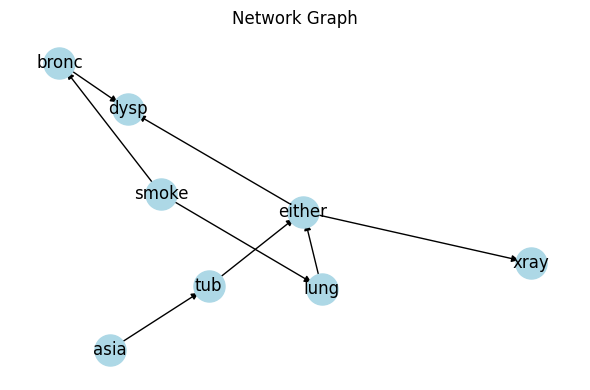

{('asia', 'tub'): 'asia->tub', ('bronc', 'dysp'): 'bronc->dysp', ('either', 'xray'): 'either->xray', ('either', 'dysp'): 'either->dysp', ('lung', 'either'): 'lung->either', ('smoke', 'lung'): 'smoke->lung', ('smoke', 'bronc'): 'smoke->bronc', ('tub', 'either'): 'tub->either'}


In [16]:
# display G
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def visualize_graph(G, title="Network Graph", layout_func=nx.spring_layout, 
                   node_color='lightblue', node_size=500, 
                   with_labels=True, arrows=True):
    """
    Visualize a NetworkX graph with customizable options.
    
    Parameters:
    -----------
    G : networkx.Graph or networkx.DiGraph
        The graph to visualize
    title : str
        Title of the plot
    layout_func : callable
        NetworkX layout function to use (e.g., nx.spring_layout, nx.circular_layout)
    node_color : str or list
        Color(s) of the nodes
    node_size : int or list
        Size(s) of the nodes
    with_labels : bool
        Whether to show node labels
    arrows : bool
        Whether to show arrow directions (for directed graphs)
    """
    plt.figure(figsize=(6, 4))
    pos = layout_func(G)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_size)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, arrows=arrows)
    
    # Draw labels if requested
    if with_labels:
        nx.draw_networkx_labels(G, pos)
    
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_graph(G)
edge_labels = {(u, v): f"{u}->{v}" for (u, v) in G.edges()}
print(edge_labels)

  0%|          | 0/8 [00:00<?, ?it/s]

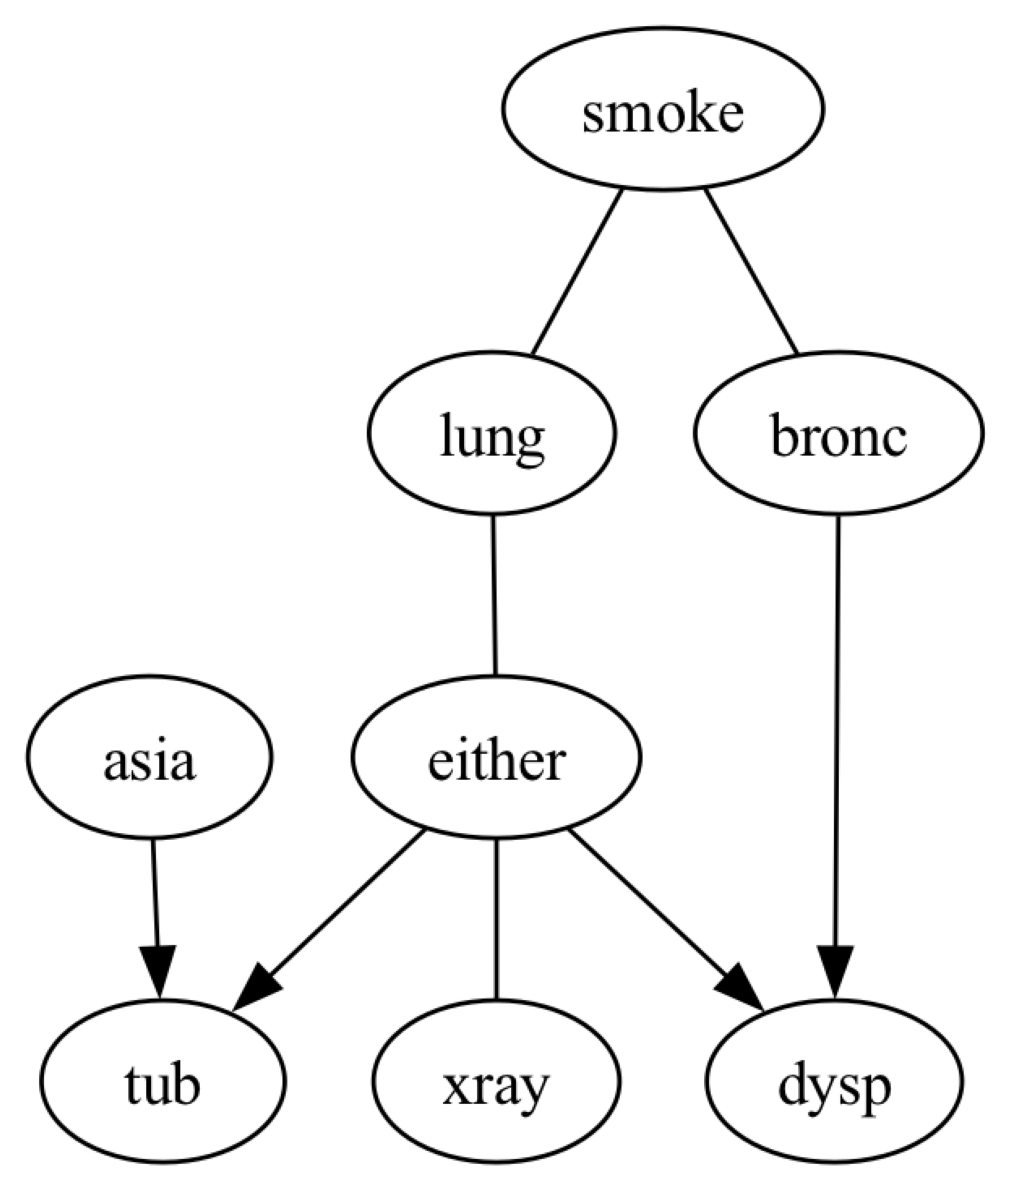

In [18]:
# apply PC algorithm
from causallearn.search.ConstraintBased.PC import pc
from causaldag import PDAG
import numpy as np

def PC(df):
    # get df column names to list
    columns = list(df.columns)

    # to numpy array
    data = df.to_numpy()
    cg = pc(data,node_names=columns)
    
    # draw the graph
    cg.draw_pydot_graph()
    return cg
    # # convert casual dag to DAG PDAG
    # # get all nodes
    # nodes = set(columns)
    
    # # get all directed edges
    # directed_edges = set()
    # undirected_edges = set()
    # for i in range(len(columns)):
    #     for j in range(i+1,len(columns)):
    #         if cg.G.graph[i,j]==-1 and cg.G.graph[j,i]==1:
    #             # directed edge i -> j
    #             directed_edges.add((columns[i],columns[j]))
    #         elif cg.G.graph[i,j]==-1 and cg.G.graph[j,i]==-1:
    #             # undirected edge i - j
    #             undirected_edges.add((columns[i],columns[j]))
    #         elif cg.G.graph[i,j]==1 and cg.G.graph[j,i]==1:
    #             # undirected edge i <-> j
    #             undirected_edges.add((columns[i],columns[j]))
    
    # # init PDAG object
    # pdag = PDAG(nodes=nodes, arcs=directed_edges, edges=undirected_edges, known_arcs=directed_edges)
    # return pdag

cg=PC(data)

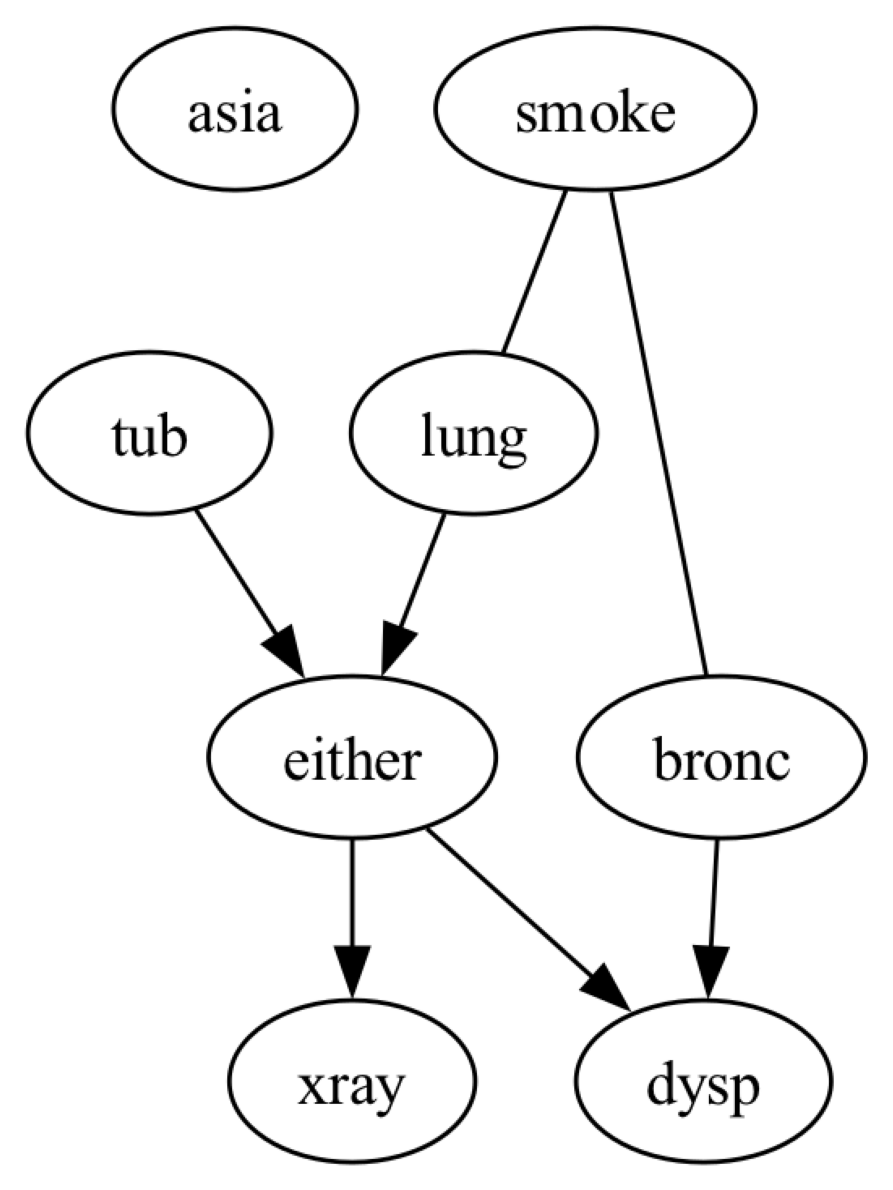

In [14]:
# apply GES algorithm
from causallearn.search.ScoreBased.GES import ges

# default parameters
Record = ges(data.to_numpy(),node_names=data.columns)
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(Record['G'])
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

In [59]:
def adj2pdag(adj, columns):
    # columns = list(df.columns), ordered list of column names
    # convert casual dag to DAG PDAG
    nodes = set(columns)
    directed_edges = set()
    undirected_edges = set()
    for i in range(len(columns)):
        for j in range(i+1,len(columns)):
            if adj[i,j]==-1 and adj[j,i]==1:
                # directed edge i -> j
                directed_edges.add((columns[i],columns[j]))
            elif adj[i,j]==-1 and adj[j,i]==-1:
                # undirected edge i - j
                undirected_edges.add((columns[i],columns[j]))
            elif adj[i,j]==1 and adj[j,i]==1:
                # undirected edge i <-> j
                undirected_edges.add((columns[i],columns[j]))
    
    # init PDAG object
    pdag = PDAG(nodes=nodes, arcs=directed_edges, edges=undirected_edges, known_arcs=directed_edges)
    return pdag

In [55]:
# compare PC, GES graphs, if the edges are the same, then the edge is considered as true, otherwise false
# cg.G.graph # 
# Record['G'].graph # j,i =1 and i,j = -1, i->j; i,j=j,i=1, i - j
def combine_pdags(pdag1, pdag2):
    """
    Combine two PDAGs by taking the union of their directed and undirected edges.
    """
    
    # create result PDAG
    n = len(pdag1)
    result = np.zeros((n, n))

    edges1 = (pdag1 != 0)
    edges2 = (pdag2 != 0)

    for i in range(n):
        for j in range(i+1):
            if i == j:
                continue
            # if edge in both PDAGs, keep it
            if edges1[i,j] and edges1[j,i] and edges2[i,j] and edges2[j,i]:
                # check if the same direction, if not, then undirected
                if pdag1[i,j]==pdag2[i,j] and pdag1[j,i]==pdag2[j,i]:
                    result[i,j]=pdag1[i,j]
                    result[j,i]=pdag1[j,i]
                else:
                    result[i,j]=-1
                    result[j,i]=-1
            # if edge in only one PDAG, keep it as undirected
            elif (edges1[i,j] and edges1[j,i]) or (edges2[i,j] and edges2[j,i]):
                result[i,j] = result[j,i] = -1
                
    return result


In [56]:
graph=combine_pdags(cg.G.graph, Record['G'].graph)
print(data.columns)
graph

Index(['asia', 'tub', 'smoke', 'lung', 'bronc', 'either', 'xray', 'dysp'], dtype='object')


array([[ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0., -1.,  0.,  0.],
       [ 0.,  0.,  0., -1., -1.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0., -1.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0., -1.],
       [ 0., -1.,  0., -1.,  0.,  0., -1., -1.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.]])

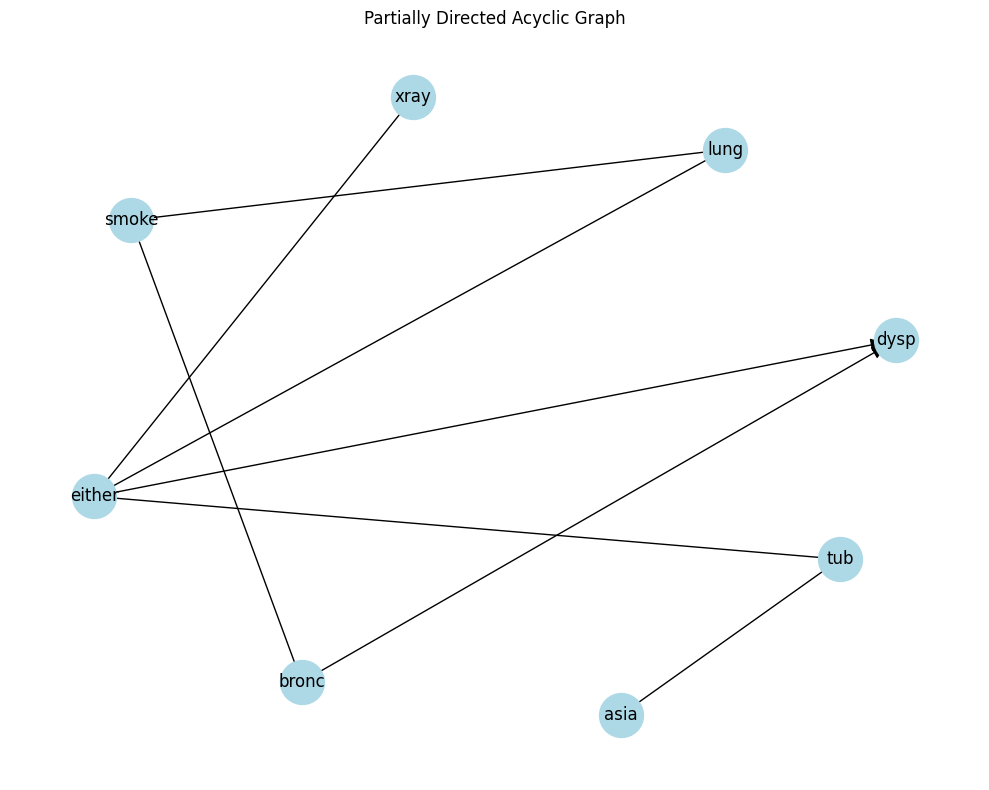

In [57]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def visualize_pdag(adj_matrix: np.ndarray, 
                  node_labels = None,
                  figsize: tuple = (10, 8),
                  node_size: int = 1000,
                  node_color: str = 'lightblue',
                  font_size: int = 12,
                  title: str = "Partially Directed Acyclic Graph") -> None:
    """
    Convert a PDAG adjacency matrix to a NetworkX graph and visualize it.
    
    Parameters:
    -----------
    adj_matrix : np.ndarray
        Adjacency matrix where:
        - i,j = 1 and j,i = -1 represents a directed edge i→j
        - i,j = j,i = 1 represents an undirected edge i—j
    node_labels : dict, optional
        Dictionary mapping node indices to labels
    figsize : tuple, optional
        Figure size for the plot
    node_size : int, optional
        Size of nodes in the visualization
    node_color : str, optional
        Color of the nodes
    font_size : int, optional
        Font size for node labels
    title : str, optional
        Title of the plot
    """
    n = len(adj_matrix)
    
    # Create empty graph
    G = nx.Graph()
    
    # Add nodes
    G.add_nodes_from(range(n))
    
    # Create directed and undirected edge lists
    directed_edges = []
    undirected_edges = []
    
    for i in range(n):
        for j in range(n):
            if adj_matrix[i,j] != 0:
                if adj_matrix[i,j] == -1 and adj_matrix[j,i] == -1:
                    # Undirected edge (only add once)
                    if (j, i) not in undirected_edges and (i, j) not in undirected_edges:
                        undirected_edges.append((i, j))
                elif adj_matrix[i,j] == -1 and adj_matrix[j,i] == 1:
                    # Directed edge
                    directed_edges.append((i, j))
    
    # Create directed and undirected graph components
    G_directed = nx.DiGraph()
    G_directed.add_nodes_from(range(n))
    G_directed.add_edges_from(directed_edges)
    
    G_undirected = nx.Graph()
    G_undirected.add_nodes_from(range(n))
    G_undirected.add_edges_from(undirected_edges)
    
    # Set up the plot
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, 
                          node_color=node_color, 
                          node_size=node_size)
    
    # Draw directed edges
    nx.draw_networkx_edges(G_directed, pos, 
                          edge_color='black',
                          arrowsize=20)
    
    # Draw undirected edges
    nx.draw_networkx_edges(G_undirected, pos, 
                          edge_color='black',
                          style='-')
    
    # Add labels
    if node_labels is None:
        node_labels = {i: str(i) for i in range(n)}
    nx.draw_networkx_labels(G, pos, 
                          node_labels, 
                          font_size=font_size)
    
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_pdag(graph, node_labels={i: data.columns[i] for i in range(len(data.columns))})

In [60]:
cpdag=adj2pdag(graph, data.columns)

In [64]:

pyd=GraphUtils.to_pydot(graph)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)

AttributeError: 'numpy.ndarray' object has no attribute 'get_nodes'

In [70]:
from causallearn.utils.DAG2CPDAG import dag2cpdag
temp=dag2cpdag(cpdag.to_dag())

AttributeError: 'DAG' object has no attribute 'get_causal_ordering'

In [76]:
cpdag.edges

{frozenset({'either', 'lung'}),
 frozenset({'lung', 'smoke'}),
 frozenset({'asia', 'tub'}),
 frozenset({'either', 'tub'}),
 frozenset({'bronc', 'smoke'}),
 frozenset({'either', 'xray'})}

In [77]:
from causaldag import DAG
def get_undirected_edges(true_G, verbose=False):

    dag = DAG.from_nx(true_G)
    edges = dag.arcs - dag.cpdag().arcs
    print(dag.cpdag().ed)

    if verbose:
        print("Unoriented edges: ", edges)
    
    return edges
get_undirected_edges(G)

{frozenset({'bronc', 'smoke'}), frozenset({'lung', 'smoke'}), frozenset({'asia', 'tub'})}


{('asia', 'tub'), ('smoke', 'bronc'), ('smoke', 'lung')}

In [78]:
from utils.dag_utils import get_mec
get_mec(cpdag)

[[('bronc', 'dysp'),
  ('either', 'xray'),
  ('either', 'lung'),
  ('lung', 'smoke'),
  ('tub', 'asia'),
  ('tub', 'either'),
  ('either', 'dysp'),
  ('smoke', 'bronc')],
 [('bronc', 'dysp'),
  ('either', 'lung'),
  ('lung', 'smoke'),
  ('xray', 'either'),
  ('tub', 'asia'),
  ('either', 'dysp'),
  ('either', 'tub'),
  ('smoke', 'bronc')],
 [('lung', 'either'),
  ('bronc', 'dysp'),
  ('smoke', 'lung'),
  ('tub', 'asia'),
  ('either', 'xray'),
  ('either', 'dysp'),
  ('either', 'tub'),
  ('bronc', 'smoke')],
 [('lung', 'either'),
  ('bronc', 'dysp'),
  ('smoke', 'lung'),
  ('either', 'xray'),
  ('tub', 'asia'),
  ('either', 'dysp'),
  ('either', 'tub'),
  ('smoke', 'bronc')],
 [('bronc', 'dysp'),
  ('either', 'xray'),
  ('either', 'lung'),
  ('lung', 'smoke'),
  ('asia', 'tub'),
  ('tub', 'either'),
  ('either', 'dysp'),
  ('smoke', 'bronc')],
 [('bronc', 'dysp'),
  ('either', 'lung'),
  ('either', 'xray'),
  ('tub', 'asia'),
  ('lung', 'smoke'),
  ('either', 'tub'),
  ('smoke', 'bronc'